# Example benchmark for `empymod`

Benchmark to check with method is fasted for the problem to solve, and check its precision.

This example benchmark uses x-directed source and receiver in the seawater layer below air and above the subsurface layers. Source is at the origin and receivers are aligned along the x-axis.
- *ab = 11*
- freq = 1*
- *lsrc = lrec* (source and receiver are in the same layer)
- *aniso, epermH, epermV, mpermH, mpermV = None*
- *xdirect = False*

### Your mileage may vary
Adjust the parameters to resemble your problem at hand. Specifically **ab**, and the **number of layers between source and receiver**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from empymod import dipole

%matplotlib inline
%load_ext memory_profiler

# Style adjustments
plt.style.use('ggplot')
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 100
rcParams['text.usetex'] = True
rcParams['font.serif'] = 'Computer Modern Roman'
rcParams['font.family'] = 'serif'
rcParams['font.style'] = 'normal'

## General model parameters

In [2]:
freq = 1
ab = 11
xdirect = False
verb = 0
zsrc = 990
zrec = 1000

# aHT : all hankel transforms in a list
aHT = ['QWE', 'FHT', 'FHT']

# aHTP : list of hankel transforms print name
aHTP = ['9pt QWE', '201pt FHT', '801pt FHT']

# aHTARG : list of arguments for hankel transforms
aHTARG = [[1e-6, 1e-24, 9, 40, 40], 'key_201_2012', 'anderson_801_1982']
# factor to decrase atol for the spline version of QWE, to much precision of spline version of filters
qwe_spline_fact = 1000

# aOPT : list of optimization arguments
aOPT = [None, 'parallel', 'spline']

## Calculation & memory estimate for biggest model

In [3]:
# Initialize Output dict
runtimes = dict()

# Loop over the various hankel transforms
for i in range(np.size(aHT)):
    HT = aHT[i]
    HTP = aHTP[i]
    HTARG = aHTARG[i]
    runtimes[HTP] = dict()
    
    # Loop over the optimizations
    for opt in aOPT:
        runtimes[HTP][opt] = np.zeros(21)
        if HTP == 'QWE' and opt == 'spline':
            HTARG[0] *= qwe_spline_fact
        print('   **   '+ HTP + '; opt = '+str(opt)+'   **')
        
        # Loop over the 21 cases (layers: 5, 22, 100; offsets: 1, 3, 10, 32, 100, 316, 1000)
        for case in range(21):
            nlay = np.logspace(0.7,2,3, dtype=int)[case//7]      # Nr of layers: 5, 22, 100
            depth = np.r_[0, 1000+np.linspace(0, 5000, nlay-2)]  # Layer top depths
            res = np.r_[1e20, 0.3, np.linspace(.1, 10, nlay-2)]  # Layer resistivities (ohm-m)
            
            noff = int(10**(case%7/2))                           # Nr of offsets: 1, 10, 100, 1000
            rec   = [np.linspace(500, min(20000, noff*500+500), noff), np.zeros(noff), zrec]

            # === EM-FIELD CALCULATION ============
            out = %timeit -q -o dipole([0, 0, zsrc], rec, depth, res, freq, ab=ab, ht=HT, htarg=HTARG, opt=opt, verb=0)
            if case == 20:
                %memit dipole([0, 0, zsrc], rec, depth, res, freq, ab=ab, ht=HT, htarg=HTARG, opt=opt, verb=0)

            runtimes[HTP][opt][case] = 1000*out.best
            print(u'%10.1f ms :: ' % runtimes[HTP][opt][case] + '  ** Layers ::', nlay, '; Offsets ::', noff, '**')
            
print('   **   FINISHED   **')

   **   9pt QWE; opt = None   **
       6.3 ms ::   ** Layers :: 5 ; Offsets :: 1 **
      11.2 ms ::   ** Layers :: 5 ; Offsets :: 3 **
      16.5 ms ::   ** Layers :: 5 ; Offsets :: 10 **
      22.7 ms ::   ** Layers :: 5 ; Offsets :: 31 **
      41.2 ms ::   ** Layers :: 5 ; Offsets :: 100 **
      97.1 ms ::   ** Layers :: 5 ; Offsets :: 316 **
     289.5 ms ::   ** Layers :: 5 ; Offsets :: 1000 **
      11.6 ms ::   ** Layers :: 22 ; Offsets :: 1 **
      22.3 ms ::   ** Layers :: 22 ; Offsets :: 3 **
      35.2 ms ::   ** Layers :: 22 ; Offsets :: 10 **
      51.6 ms ::   ** Layers :: 22 ; Offsets :: 31 **
     105.5 ms ::   ** Layers :: 22 ; Offsets :: 100 **
     265.7 ms ::   ** Layers :: 22 ; Offsets :: 316 **
     834.8 ms ::   ** Layers :: 22 ; Offsets :: 1000 **
      33.5 ms ::   ** Layers :: 100 ; Offsets :: 1 **
      61.1 ms ::   ** Layers :: 100 ; Offsets :: 3 **
      97.9 ms ::   ** Layers :: 100 ; Offsets :: 10 **
     163.0 ms ::   ** Layers :: 100 ; Offsets :: 31

## Figure Normal/Parallel/Spline

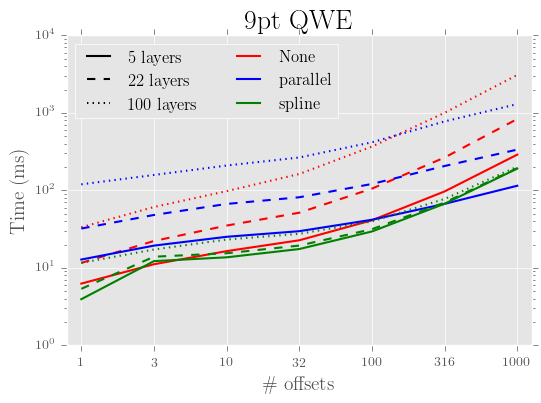

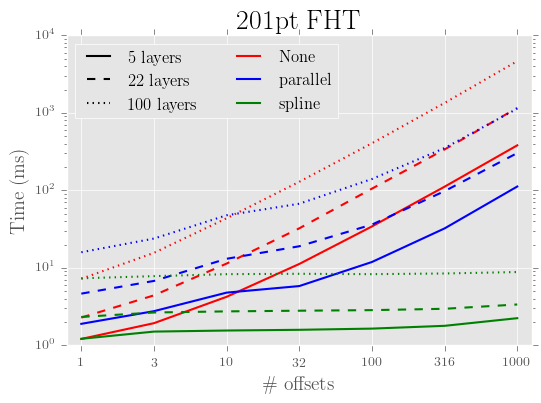

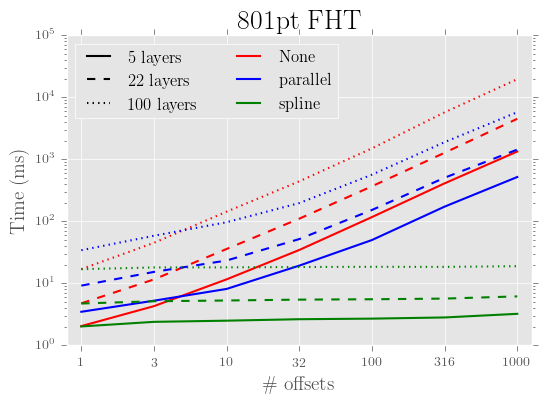

In [4]:
for i in range(np.size(aHT)):
    x = np.arange(7)
    
    lw1 = 1.5
    
    fig = plt.figure()
    plt.title(aHTP[i], fontsize=20)
    plt.plot(-1, 1, 'k-', lw=lw1, label='5 layers')
    plt.plot(-1, 1, 'k--', lw=lw1, label='22 layers')
    plt.plot(-1, 1, 'k:', lw=lw1, label='100 layers')
    plt.plot(-1, 1, 'r', lw=lw1, label='None')
    plt.plot(-1, 1, 'b', lw=lw1, label=aOPT[1])
    plt.plot(-1, 1, 'g', lw=lw1, label=aOPT[2])

    plt.semilogy(x, runtimes[aHTP[i]][aOPT[0]][:7], 'r-', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[i]][aOPT[0]][7:14], 'r--', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[i]][aOPT[0]][14:], 'r:', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[i]][aOPT[1]][:7], 'b-', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[i]][aOPT[1]][7:14], 'b--', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[i]][aOPT[1]][14:], 'b:', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[i]][aOPT[2]][:7], 'g-', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[i]][aOPT[2]][7:14], 'g--', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[i]][aOPT[2]][14:], 'g:', lw=lw1)

    plt.xticks([0,1,2,3,4,5,6], (1, 3, 10, 32, 100, 316, 1000))
    plt.xlabel(r'\# offsets', fontsize=14)
    plt.ylabel(r'Time (ms)', fontsize=14)
    plt.legend(loc='best', fontsize=12, ncol=2)
    plt.xlim([-.2, 6.2])

    plt.show()

## Figure QWE/FHT

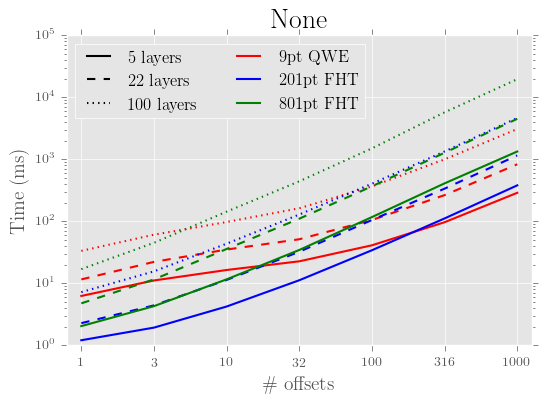

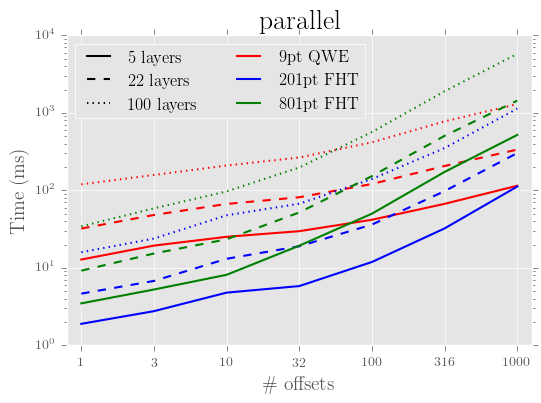

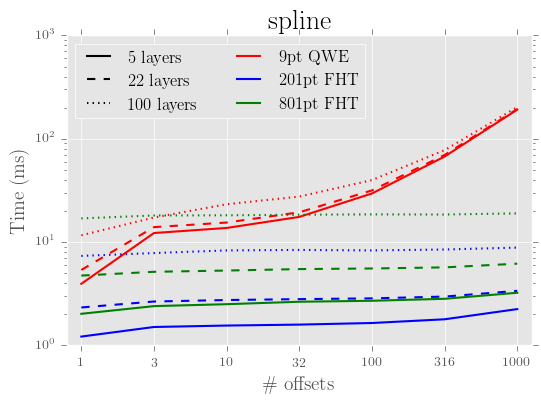

In [5]:
for i in range(np.size(aOPT)):
    x = np.arange(7)
    
    lw1 = 1.5
    
    fig = plt.figure()
    plt.title(aOPT[i], fontsize=20)
    plt.plot(-1, 1, 'k-', lw=lw1, label='5 layers')
    plt.plot(-1, 1, 'k--', lw=lw1, label='22 layers')
    plt.plot(-1, 1, 'k:', lw=lw1, label='100 layers')
    plt.plot(-1, 1, 'r', lw=lw1, label=aHTP[0])
    plt.plot(-1, 1, 'b', lw=lw1, label=aHTP[1])
    plt.plot(-1, 1, 'g', lw=lw1, label=aHTP[2])

    plt.semilogy(x, runtimes[aHTP[0]][aOPT[i]][:7], 'r-', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[0]][aOPT[i]][7:14], 'r--', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[0]][aOPT[i]][14:], 'r:', lw=lw1)
    
    plt.semilogy(x, runtimes[aHTP[1]][aOPT[i]][:7], 'b-', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[1]][aOPT[i]][7:14], 'b--', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[1]][aOPT[i]][14:], 'b:', lw=lw1)
    
    plt.semilogy(x, runtimes[aHTP[2]][aOPT[i]][:7], 'g-', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[2]][aOPT[i]][7:14], 'g--', lw=lw1)
    plt.semilogy(x, runtimes[aHTP[2]][aOPT[i]][14:], 'g:', lw=lw1)

    plt.xticks([0,1,2,3,4,5,6], (1, 3, 10, 32, 100, 316, 1000))
    plt.xlabel(r'\# offsets', fontsize=14)
    plt.ylabel(r'Time (ms)', fontsize=14)
    plt.legend(loc='best', fontsize=12, ncol=2)
    plt.xlim([-.2, 6.2])

    plt.show()

## Error levels

In [6]:
nlay = 22      # Nr of layers: 5, 22, 100
depth = np.r_[0, 1000+np.linspace(0, 5000, nlay-2)]  # Layer top depths
res = np.r_[1e20, 0.3, np.linspace(.1, 10, nlay-2)]  # Layer resistivities (ohm-m)

noff = 100                           # Nr of offsets: 1, 10, 100, 1000
rec   = [np.linspace(500, min(20000, noff*500+500), noff), np.zeros(noff), zrec]

ref = dipole([0, 0, zsrc], rec, depth, res, freq, ab=ab, ht=aHT[0], htarg=[1e-14, 1e-24, 51], opt=False, verb=0)

qwe = dipole([0, 0, zsrc], rec, depth, res, freq, ab=ab, ht=aHT[0], htarg=aHTARG[0], opt=None, verb=0)
qwesp = dipole([0, 0, zsrc], rec, depth, res, freq, ab=ab, ht=aHT[0], htarg=aHTARG[0], opt='spline', verb=0)

fht201 = dipole([0, 0, zsrc], rec, depth, res, freq, ab=ab, ht=aHT[1], htarg=aHTARG[1], opt=None, verb=0)
fht201sp = dipole([0, 0, zsrc], rec, depth, res, freq, ab=ab, ht=aHT[1], htarg=aHTARG[1], opt='spline', verb=0)

fht801 = dipole([0, 0, zsrc], rec, depth, res, freq, ab=ab, ht=aHT[2], htarg=aHTARG[2], opt=None, verb=0)
fht801sp = dipole([0, 0, zsrc], rec, depth, res, freq, ab=ab, ht=aHT[2], htarg=aHTARG[2], opt='spline', verb=0)

* WARNING :: Hankel-QWE used all 40 intervals; set `maxint` higher.


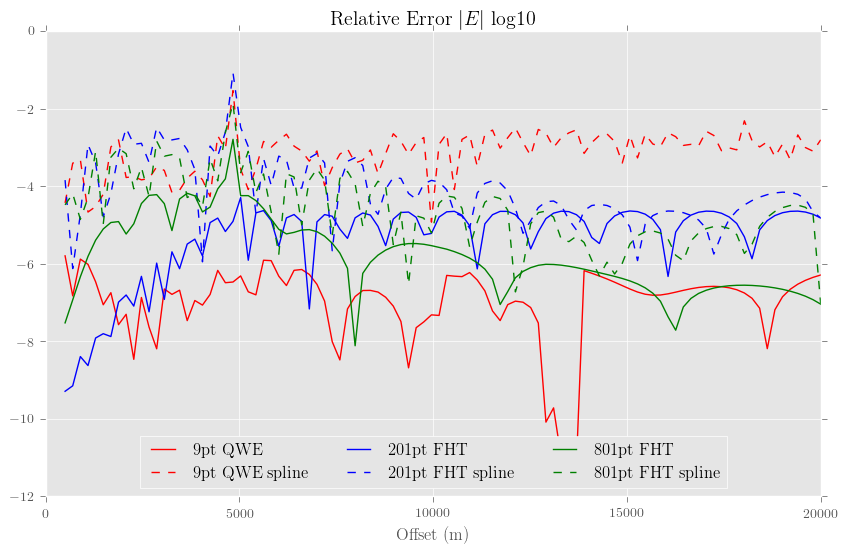

In [7]:
# Figure
fig = plt.figure(figsize=(10,6))
plt.title(r'Relative Error $|E|$ log10')
plt.xlabel('Offset (m)')

## ABS ERROR ##
plt.plot(rec[0], np.log10(np.abs((qwe-ref)/ref)), 'r', label='9pt QWE')
plt.plot(rec[0], np.log10(np.abs((qwesp-ref)/ref)), 'r--', label='9pt QWE spline')
plt.plot(rec[0], np.log10(np.abs((fht201-ref)/ref)), 'b-', label='201pt FHT')
plt.plot(rec[0], np.log10(np.abs((fht201sp-ref)/ref)), 'b--', label='201pt FHT spline')
plt.plot(rec[0], np.log10(np.abs((fht801-ref)/ref)), 'g-', label='801pt FHT')
plt.plot(rec[0], np.log10(np.abs((fht801sp-ref)/ref)), 'g--', label='801pt FHT spline')

plt.legend(loc='lower center', ncol=3)
plt.show()